In [1]:
import Pkg; Pkg.instantiate(); Pkg.activate()

  Activating project at `~/.julia/environments/v1.10`


In [2]:
using RxInfer
using Distributions
using Random
using GraphPlot
using Graphs
using MetaGraphsNext
using GraphPPL
using GraphViz
using Dictionaries
using Plots
using StableRNGs
using LinearAlgebra
using StatsPlots
using LaTeXStrings
using DataFrames
using CSV
using GLM

using Cairo # necessary for draw PDF...
using Fontconfig # necessary for draw PDF...
using Compose # necessary for draw PDF...

# Current GraphViz Functionality Demo

# Coin-toss Model

In this example, we are going to perform an exact inference for a coin-toss model that can be represented as:

\begin{align}
    p(\theta) &= \text{Beta}(\theta | a, b)\\
    p(y_i | \theta) &= \text{Bernoulli}(y_i | \theta)
\end{align}

Where $y_i \in \{0, 1\}$ is a binary observation induced by Bernoulli likelihood while $\theta$ is a Beta prior distribution on the parameter of the Bernoulli Likelihood. We are interested in inferring the posterior distribution of $\theta$.

The joint probability is given by the multiplication of the likelihood and the prior, i.e.

\begin{equation}
    p(y_{1:N}, \theta) = p(\theta) \prod_{i=1}^{N} p(y_i | \theta)
\end{equation}

We can specify this model (the joint distribution) using GraphPPL's package syntax.

In [3]:
# GraphPPL.jl export `@model` macro for model specification
# It accepts a regular Julia function and builds an FFG under the hood
@model function coin_model(y, a, b)
    # We endow θ parameter of our model with some prior
    θ ~ Beta(a, b)
    # or, in this particular case, the `Uniform(0.0, 1.0)` prior also works:
    # θ ~ Uniform(0.0, 1.0)

    # We assume that outcome of each coin flip is governed by the Bernoulli distribution
    for i in eachindex(y)
        y[i] ~ Bernoulli(θ)
    end
end

In [4]:
conditioned = coin_model(a = 2.0, b = 7.0) | (y = [ true, false, true ], );

In [5]:
# `Create` the actual graph of the model conditioned on the data
rxi_model = RxInfer.create_model(conditioned);

In [6]:
gppl_model = RxInfer.getmodel(rxi_model);

In [7]:
# Extract the MetaGraphsNext graph
meta_graph = gppl_model.graph;

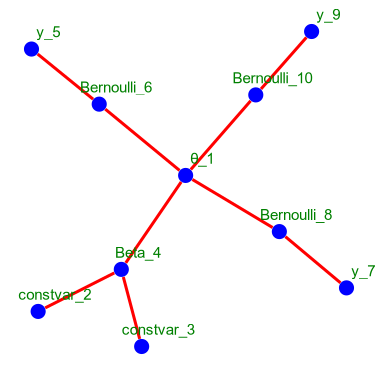

In [8]:
# The existing plotting functionality:
p = GraphPlot.gplot(
    meta_graph,
    layout=spring_layout,
#     nodelabel=collect(labels(meta_graph)),
    nodelabel=collect(labels(meta_graph)),
    nodelabelsize=1.0,
    NODESIZE=0.05, # diameter of the nodes,
    nodelabelc="green",
    nodelabeldist=3.0,
    nodefillc="blue",
    edgestrokec="red",
    EDGELINEWIDTH = 0.8
)

In [9]:
layout=(args...)->spring_layout(args...; C=2)

draw(
    PDF(
        "coin_toss_model_default.pdf", 30cm, 30cm
    ), GraphPlot.gplot(
        meta_graph,
        layout=layout,
        nodelabel=collect(labels(meta_graph)),
        nodelabelsize=1.0,
        NODESIZE=0.05, # diameter of the nodes,
        nodelabelc="green",
        nodelabeldist=3.0,
        nodefillc="blue",
        edgestrokec="red",
        EDGELINEWIDTH = 0.8
    )
)

# Querying The Structure of The Graph

## Contexts

After creating a GraphPPL.Model structure, it is important to know about the attached Context. The Context structure contains all variable and factor nodes in the scope of the model, and contains a Context stucture for all submodels. The context of a model can be accessed by the ```GraphPPL.getcontext()``` function:

In [10]:
fieldnames(GraphPPL.Context)

(:depth, :fform, :prefix, :parent, :submodel_counts, :children, :factor_nodes, :individual_variables, :vector_variables, :tensor_variables, :proxies, :returnval)

In [11]:
gppl_model_context = GraphPPL.getcontext(gppl_model)

Context()
 Individual variables: {:constvar_2, :θ, :constvar_3}
 Vector variables: {:y}
 Tensor variables: {}
 Proxies: {}
 Factor nodes: GraphPPL.FactorID[(Beta, 1), (Bernoulli, 2), (Bernoulli, 1), (Bernoulli, 3)]


In [12]:
function gppl_global_context_info(model::GraphPPL.Model)
    
    context = GraphPPL.getcontext(model)
    
    println("Individual variables: ", context.individual_variables)
    println("Vector variables: ", context.vector_variables)
    println("Tensor variables: ", context.tensor_variables)
    println("Proxies: ", context.proxies)
    println("Factor nodes: ", context.factor_nodes)
    println("Depth: ", context.depth)
    println("Prefix: ", context.prefix)
    println("Parent: ", context.parent)
    println("Submodel counts: ", context.submodel_counts)
    println("Children: ", context.children)
    println("Returnval: ", context.returnval)
    println("------------------------------------- Factor Nodes -------------------------------------")
    
    for factor_node in context.factor_nodes
        node_data = model[factor_node]
        println("Factor Node: ", factor_node)
        println("  Form: ", node_data.properties.fform)
        println("  Neighbors:")
        for (label, edge, neighbor) in node_data.properties.neighbors
            println("    - Label: ", label)
            println("      Edge: ", edge)
            println("      Neighbor: ", neighbor)
            println("      Type of Neighbor: ", typeof(neighbor))
            println()
        end
    end
end

gppl_global_context_info (generic function with 1 method)

In [13]:
gppl_global_context_info(gppl_model)

Individual variables: {:constvar_2 = constvar_2, :θ = θ_1, :constvar_3 = constvar_3}
Vector variables: {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_5, y_7, y_9])}
Tensor variables: {}
Proxies: {}
Factor nodes: {(Beta, 1) = Beta_4, (Bernoulli, 2) = Bernoulli_8, (Bernoulli, 1) = Bernoulli_6, (Bernoulli, 3) = Bernoulli_10}
Depth: 0
Prefix: 
Parent: nothing
Submodel counts: {Beta = 1, Bernoulli = 3}
Children: {}
Returnval: Base.RefValue{Any}(nothing)
------------------------------------- Factor Nodes -------------------------------------
Factor Node: Beta_4
  Form: Beta
  Neighbors:
    - Label: θ_1
      Edge: out
      Neighbor: NodeData in context  with properties name = θ, index = nothing
      Type of Neighbor: GraphPPL.NodeData

    - Label: constvar_2
      Edge: a
      Neighbor: NodeData in context  with properties name = constvar, index = nothing
      Type of Neighbor: GraphPPL.NodeData

    - Label: constvar_3
      Edge: b
      Neighbor: NodeData in context

In [14]:
for (factor_ID, factor_label) in pairs(gppl_model_context.factor_nodes)
#     println("$(factor_ID), $(factor_label)")
#     println("$(typeof(factor_ID)), $(typeof(factor_label))")
    node_data = gppl_model[factor_label]
    println("$(node_data.properties.fform)\n")
end

Beta

Bernoulli

Bernoulli

Bernoulli



In [15]:
gppl_model_context.factor_nodes

4-element UnorderedDictionary{GraphPPL.FactorID, GraphPPL.NodeLabel}
      (Beta, 1) │ Beta_4
 (Bernoulli, 2) │ Bernoulli_8
 (Bernoulli, 1) │ Bernoulli_6
 (Bernoulli, 3) │ Bernoulli_10

# Experimentation

In [16]:
gppl_model.counter

Base.RefValue{Int64}(10)

In [17]:
println(typeof(label_for(gppl_model.graph, 1)))
println(label_for(gppl_model.graph, 1))

GraphPPL.NodeLabel
θ_1


In [37]:
for vertex in MetaGraphsNext.vertices(meta_graph)
    label = MetaGraphsNext.label_for(meta_graph, vertex)
    println("Node: ", vertex, ", Label: ", label)
#     println("typeof(Node): ", typeof(vertex), ", typeof(Label): ", typeof(label))
end

Node: 1, Label: θ_1
Node: 2, Label: constvar_2
Node: 3, Label: constvar_3
Node: 4, Label: Beta_4
Node: 5, Label: y_5
Node: 6, Label: Bernoulli_6
Node: 7, Label: y_7
Node: 8, Label: Bernoulli_8
Node: 9, Label: y_9
Node: 10, Label: Bernoulli_10


In [19]:
collect(labels(gppl_model.graph))

10-element Vector{GraphPPL.NodeLabel}:
 θ_1
 constvar_2
 constvar_3
 Beta_4
 y_5
 Bernoulli_6
 y_7
 Bernoulli_8
 y_9
 Bernoulli_10

In [11]:
MetaGraphsNext.nv(meta_graph)

10

In [12]:
MetaGraphsNext.nv(meta_graph)

10

In [13]:
Graphs.nv(meta_graph)

10

In [14]:
GraphPPL.MetaGraphsNext.label_for(meta_graph, 1)

θ_1

# GraphViz DOT Code Generation and Visualisation (P.O.C)

In [31]:
MetaGraphsNext.vertices(meta_graph)

Base.OneTo(10)

In [ ]:
# function write_vertex_info(
#         meta_graph::MetaGraph, io_buffer::Base.IOBuffer
#     )
#     for vertex in MetaGraphsNext.vertices(meta_graph)
#         label = MetaGraphsNext.label_for(meta_graph, vertex)
        
#         properties = Model[label].properties # for dsistnguishing factor/variable nodes
        
#         if isa(properties, GraphPPL.FactorNodeProperties) # Factor node
#             write(io_buffer, "    \"$(label)\" [shape=square, style=filled, fillcolor=lightgray];\n")
#         elseif isa(properties, GraphPPL.VariableNodeProperties) # Variable Node
#             write(io_buffer, "    \"$(label)\" [shape=circle];\n")
#         else
#             println("ERROR: Unknown node type for label $(label)")
#         end
#     end
# end

In [10]:
"""
Parses the input GraphPPL.Model and uses Base.IOBuffer to 
iteratively construct a Julia string,containing the DOT 
code for the GraphViz visualisation of the graph. This 
string is then returned. 

Currently isomorphic to the display given by GraphPlot.gplot.
"""
function generate_dot(; 
        Model::GraphPPL.Model, font_size::Int, 
        edge_length::Float64 = 1.0, layout::String="neato", 
        width::Float64=10.0, height::Float64=10.0,
    )
    
    meta_graph = Model.graph # underlying MetaGraphsNext graph
    
    io_buffer = IOBuffer() # use Base.IOBuffer rather than sucessive string concatenation
    
    write(io_buffer, "dot\"\"\"\ngraph G {\n")
    write(io_buffer, "    layout=$(layout);\n")
    write(io_buffer, "    size=\"$(width),$(height)!\";\n")
    write(io_buffer, "    node [shape=circle, fontsize=$(font_size)];\n") # write initial graph DOT code to the Base.IOBuffer
    
    # Vertices/Nodes
    for vertex in MetaGraphsNext.vertices(meta_graph)
        label = MetaGraphsNext.label_for(meta_graph, vertex)
        
        properties = Model[label].properties # for dsistnguishing factor/variable nodes
        
        if isa(properties, GraphPPL.FactorNodeProperties) # Factor node
            write(io_buffer, "    \"$(label)\" [shape=square, style=filled, fillcolor=lightgray];\n")
        elseif isa(properties, GraphPPL.VariableNodeProperties) # Variable Node
            write(io_buffer, "    \"$(label)\" [shape=circle];\n")
        else
            println("ERROR: Unknown node type for label $(label)")
        end
    end
    
    # Edges
    for edge in MetaGraphsNext.edges(meta_graph)
        source_vertex = MetaGraphsNext.label_for(meta_graph, edge.src)
        dest_vertex = MetaGraphsNext.label_for(meta_graph, edge.dst)
        write(io_buffer, "    \"$(source_vertex)\" -- \"$(dest_vertex)\" [len=$(edge_length)];\n")
    end
    
    write(io_buffer, "}\n\"\"\"")
    
    final_dot_code = String(take!(io_buffer))
    
    return final_dot_code
    
end

generate_dot

In [11]:
"""
Takes the DOT string given by generate_dot and 
executes it to produce a GraphViz visualisation. 
"""
function show_gv(dot_code_graph::String)
    eval(Meta.parse(dot_code_graph))
end

show_gv

In [12]:
# create the DOT code string
coin_toss_dot = generate_dot(
    Model = gppl_model, 
    font_size = 7,
    edge_length = 1.0,
    layout = "neato",
    width = 6.0,
    height = 6.0
);

In [54]:
# # Define the output file path
# output_file_path = "coin_toss_graph.txt"

# # Write the DOT content to the file
# open(output_file_path, "w") do file
#     write(file, coin_toss_dot)
# end

888

In [150]:
# Optionally write the DOT string to a file:
# file_name = "coin_toss_graph.dot"

# open(file_name, "w") do file
#     write(file, coin_toss_dot)
# end

903

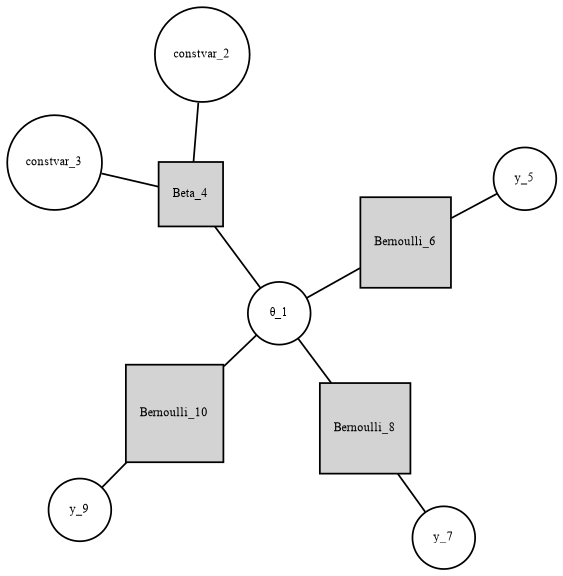

In [13]:
# execute the DOT code string
show_gv(coin_toss_dot)

# Experimental

In [36]:
# based on _bfs_parents found here: https://github.com/JuliaGraphs/Graphs.jl/blob/f97b4afd17e1cd938e53282bcb76c1b8e2ea127c/src/traversals/bfs.jl#L21-L34
function generate_dot_BFS(;
        Model::GraphPPL.Model, font_size::Int, 
        edge_length::Float64 = 1.0, layout::String="neato", 
        width::Float64=10.0, height::Float64=10.0
    )
        
    n = nv(Model) # number of vertices
    visited = falses(n) # array of visited nodes
    parents = zeros(Int, n) # array to store parent of each vertex in BFS traversal.
    cur_level = Vector{Int}() # empty vector to keep track of current level of nodes processed in BFS.
    sizehint!(cur_level, n)
    next_level = Vector{Int}()
    sizehint!(next_level, n)
    k = 0
    
    s = 1 # source node
    io_buffer = IOBuffer()
    
    write(io_buffer, "dot\"\"\"\ngraph G {\n")
    write(io_buffer, "    layout=$(layout);\n")
    write(io_buffer, "    size=\"$(width),$(height)!\";\n")
    write(io_buffer, "    node [shape=circle, fontsize=$(font_size)];\n")
    
    if !visited[s]
        visited[s] = true
        push!(cur_level, s)
        parents[s] = s
        k += 1
    end
    while !isempty(cur_level)
        for v in cur_level
            for v_neighb in MetaGraphsNext.neighbors(Model.graph, v) # v_neighb should be element in MetaGraphsNext.vertices(meta_graph)
                if !visited[v_neighb]

                    # node/vertex data:
                    label = MetaGraphsNext.label_for(Model.graph, v_neighb)
        
                    properties = Model[label].properties # for dsistnguishing factor/variable nodes

                    if isa(properties, GraphPPL.FactorNodeProperties) # Factor node
                        write(io_buffer, "    \"$(label)\" [shape=square, style=filled, fillcolor=lightgray];\n")
                    elseif isa(properties, GraphPPL.VariableNodeProperties) # Variable Node
                        write(io_buffer, "    \"$(label)\" [shape=circle];\n")
                    else
                        println("ERROR: Unknown node type for label $(label)")
                    end
                    
                    # edge data:                    
                    v_label = MetaGraphsNext.label_for(Model.graph, v)
                    v_neighb_label = MetaGraphsNext.label_for(Model.graph, v_neighb)
                    
                    write(io_buffer, "    \"$(v_label)\" -- \"$(v_neighb_label)\" [len=$(edge_length)];\n")
                    
                    push!(next_level, v_neighb)
                    parents[v_neighb] = v
                    visited[v_neighb] = true
                    k += 1
                        
                end
            end

            if k == n
                write(io_buffer, "}\n\"\"\"")
    
                final_dot_code = String(take!(io_buffer))
                    
                return final_dot_code, parents
            end
        end
        empty!(cur_level)
        cur_level, next_level = next_level, cur_level
        sort!(cur_level)
    end
    
    write(io_buffer, "}\n\"\"\"")
    
    final_dot_code = String(take!(io_buffer))

    return final_dot_code, parents
end

generate_dot_BFS (generic function with 1 method)

In [15]:
coin_toss_dot_BFS, parents = generate_dot_BFS(
    Model = gppl_model, 
    font_size = 7,
    edge_length = 1.0,
    layout = "neato",
    width = 6.0,
    height = 6.0
);

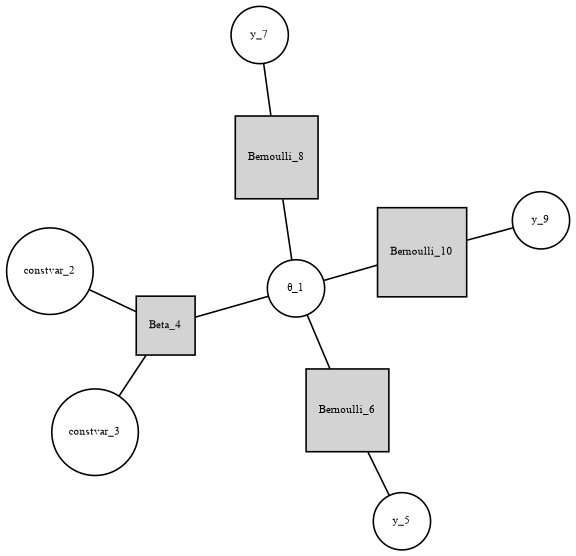

In [16]:
# execute the DOT code string
show_gv(coin_toss_dot_BFS)

In [30]:
# for node in BFSIterator(gppl_model, 1)
#     println(node)
# end

In [83]:
# Perform BFS and get the BFS tree
source = 1
bfs_tree_graph = bfs_tree(meta_graph.graph, source)
bfs_parents_arr = bfs_parents(meta_graph.graph, source) # bfs_parents_arr[i] = parent of node i

10-element Vector{Int64}:
  1
  4
  4
  1
  6
  1
  8
  1
 10
  1

In [54]:
typeof(bfs_tree_graph)

SimpleDiGraph{Int64}

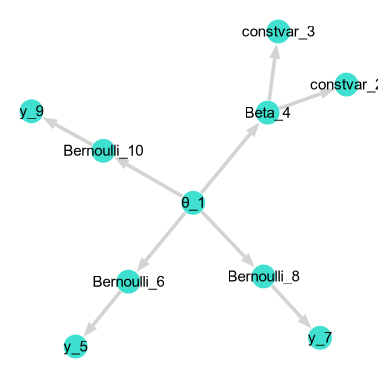

In [74]:
GraphPlot.gplot(
    bfs_tree_graph,
    nodelabel=collect(labels(meta_graph))
)

In [40]:
MetaGraphsNext.neighbors(meta_graph, 1)

4-element Vector{Int64}:
  4
  6
  8
 10

In [76]:
typeof(bfs_tree_graph)

SimpleDiGraph{Int64}

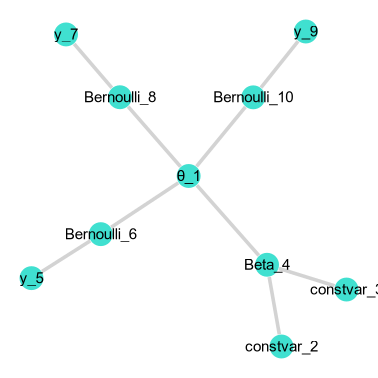

In [65]:
GraphPlot.gplot(
    meta_graph.graph,
    nodelabel=collect(labels(meta_graph))
)

In [72]:
meta_graph

Meta graph based on a SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Beta = 1, Bernoulli = 3}, {}, {(Beta, 1) = Beta_4, (Bernoulli, 2) = Bernoulli_8, (Bernoulli, 1) = Bernoulli_6, (Bernoulli, 3) = Bernoulli_10}, {:constvar_2 = constvar_2, :θ = θ_1, :constvar_3 = constvar_3}, {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_5, y_7, y_9])}, {}, {}, Base.RefValue{Any}(nothing)), and default weight 1.0

In [85]:
GraphPPL.MetaGraphsNext.label_for(meta_graph, bfs_parents_arr[1])

θ_1

In [86]:
GraphPPL.MetaGraphsNext.label_for(meta_graph, 1)

θ_1

In [90]:
for i in 1:nv(meta_graph)
    println(GraphPPL.MetaGraphsNext.label_for(meta_graph, i))
end

θ_1
constvar_2
constvar_3
Beta_4
y_5
Bernoulli_6
y_7
Bernoulli_8
y_9
Bernoulli_10


In [91]:
for i in 1:nv(meta_graph)
    println(GraphPPL.MetaGraphsNext.label_for(meta_graph, bfs_parents_arr[i]))
end

θ_1
Beta_4
Beta_4
θ_1
Bernoulli_6
θ_1
Bernoulli_8
θ_1
Bernoulli_10
θ_1


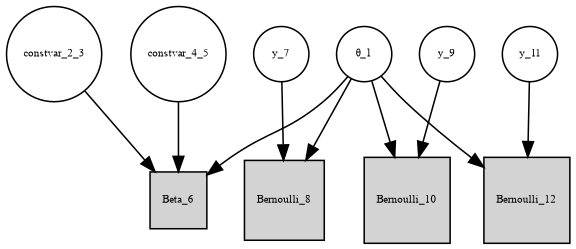

In [26]:
dot"""
digraph G {
    layout=dot;
    size="6.0,6.0!";
    node [shape=circle, fontsize=7];

    // Define root node
    "θ_1" [shape=circle];

    // Other nodes
    "constvar_2_3" [shape=circle];
    "constvar_4_5" [shape=circle];
    "Beta_6" [shape=square, style=filled, fillcolor=lightgray];
    "y_7" [shape=circle];
    "Bernoulli_8" [shape=square, style=filled, fillcolor=lightgray];
    "y_9" [shape=circle];
    "Bernoulli_10" [shape=square, style=filled, fillcolor=lightgray];
    "y_11" [shape=circle];
    "Bernoulli_12" [shape=square, style=filled, fillcolor=lightgray];

    // Define edges
    "θ_1" -> "Beta_6";
    "θ_1" -> "Bernoulli_8";
    "θ_1" -> "Bernoulli_10";
    "θ_1" -> "Bernoulli_12";
    "constvar_2_3" -> "Beta_6";
    "constvar_4_5" -> "Beta_6";
    "y_7" -> "Bernoulli_8";
    "y_9" -> "Bernoulli_10";
    "y_11" -> "Bernoulli_12";

    // Ensure "θ_1" is the root node
    { rank = min; "θ_1"; }

    // Define ranks to ensure top-down hierarchy
    { rank = same; "Beta_6"; "Bernoulli_8"; "Bernoulli_10"; "Bernoulli_12"; }
    { rank = same; "constvar_2_3"; "constvar_4_5"; "y_7"; "y_9"; "y_11"; }
}
"""

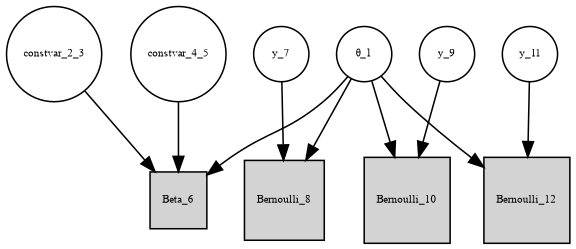

In [23]:
dot"""
digraph G {
    layout=dot;  // Use dot layout for hierarchical structure
    size="6.0,6.0!";
    node [shape=circle, fontsize=7];
    
    // Define root node
    "θ_1" [shape=circle];
    
    // Other nodes
    "constvar_2_3" [shape=circle];
    "constvar_4_5" [shape=circle];
    "Beta_6" [shape=square, style=filled, fillcolor=lightgray];
    "y_7" [shape=circle];
    "Bernoulli_8" [shape=square, style=filled, fillcolor=lightgray];
    "y_9" [shape=circle];
    "Bernoulli_10" [shape=square, style=filled, fillcolor=lightgray];
    "y_11" [shape=circle];
    "Bernoulli_12" [shape=square, style=filled, fillcolor=lightgray];
    
    // Define edges
    "θ_1" -> "Beta_6" [len=1.0];
    "θ_1" -> "Bernoulli_8" [len=1.0];
    "θ_1" -> "Bernoulli_10" [len=1.0];
    "θ_1" -> "Bernoulli_12" [len=1.0];
    "constvar_2_3" -> "Beta_6" [len=1.0];
    "constvar_4_5" -> "Beta_6" [len=1.0];
    "y_7" -> "Bernoulli_8" [len=1.0];
    "y_9" -> "Bernoulli_10" [len=1.0];
    "y_11" -> "Bernoulli_12" [len=1.0];

    // Ensure "θ_1" is the root node
    { rank = min; "θ_1"; }

    // Define ranks to ensure top-down hierarchy
    { rank = same; "constvar_2_3"; "constvar_4_5"; }
    { rank = same; "Beta_6"; "Bernoulli_8"; "Bernoulli_10"; "Bernoulli_12"; }
    { rank = same; "y_7"; "y_9"; "y_11"; }
}
"""

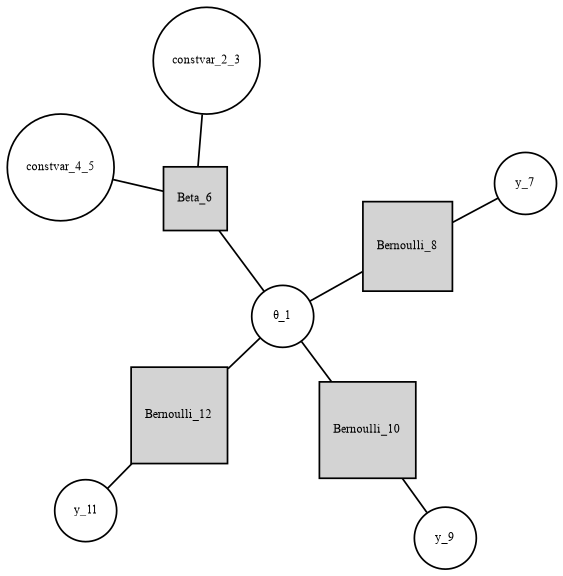

In [18]:
# this is the above DOT for the coin-toss model
dot"""
graph G {
    layout=neato;
    size="6.0,6.0!";
    node [shape=circle, fontsize=7];
    "θ_1" [shape=circle];
    "constvar_2_3" [shape=circle];
    "constvar_4_5" [shape=circle];
    "Beta_6" [shape=square, style=filled, fillcolor=lightgray];
    "y_7" [shape=circle];
    "Bernoulli_8" [shape=square, style=filled, fillcolor=lightgray];
    "y_9" [shape=circle];
    "Bernoulli_10" [shape=square, style=filled, fillcolor=lightgray];
    "y_11" [shape=circle];
    "Bernoulli_12" [shape=square, style=filled, fillcolor=lightgray];
    "θ_1" -- "Beta_6" [len=1.0];
    "θ_1" -- "Bernoulli_8" [len=1.0];
    "θ_1" -- "Bernoulli_10" [len=1.0];
    "θ_1" -- "Bernoulli_12" [len=1.0];
    "constvar_2_3" -- "Beta_6" [len=1.0];
    "constvar_4_5" -- "Beta_6" [len=1.0];
    "y_7" -- "Bernoulli_8" [len=1.0];
    "y_9" -- "Bernoulli_10" [len=1.0];
    "y_11" -- "Bernoulli_12" [len=1.0];
}
"""

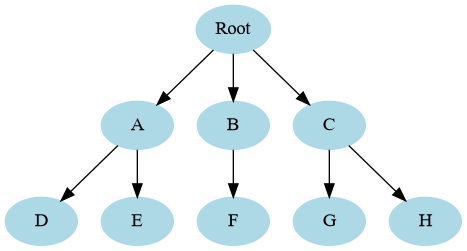

In [14]:
dot"""
digraph Tree {
    // Set the layout engine to dot
    layout = dot;

    // Graph attributes
    rankdir = TB;  // Top to Bottom layout

    // Define nodes
    node [shape = ellipse, style=filled, color=lightblue];  // Example node style

    // Define the edges to represent the tree structure
    Root -> A;
    Root -> B;
    Root -> C;
    A -> D;
    A -> E;
    B -> F;
    C -> G;
    C -> H;

    // Optional: Define subgraphs to force specific nodes to be on the same level
    {
        rank = same; A; B; C;
    }
    {
        rank = same; D; E; F; G; H;
    }
}
"""

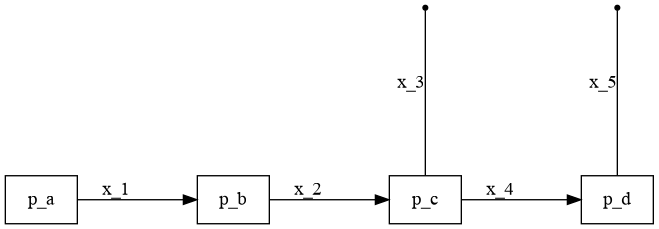

In [39]:
dot"""
digraph ForneyFactorGraph {
    // Nodes (factors) with custom positions
    pa [label="p_a", shape=box, pos="0,0!"];
    pb [label="p_b", shape=box, pos="2,0!"];
    pc [label="p_c", shape=box, pos="4,0!"];
    pd [label="p_d", shape=box, pos="6,0!"];

    // Edges (variables)
    pa -> pb [label="x_1", len=2.0];
    pb -> pc [label="x_2", len=2.0];
    pc -> x3 [label="x_3", arrowhead=none, len=2.0];
    pd -> x5 [label="x_5", arrowhead=none, len=2.0];
    pc -> pd [label="x_4", len=2.0];

    // Invisible nodes for half-edges
    x3 [shape=point, pos="4,2!"];
    x5 [shape=point, pos="6,2!"];

    // Set layout style
    layout = "neato";
}
"""

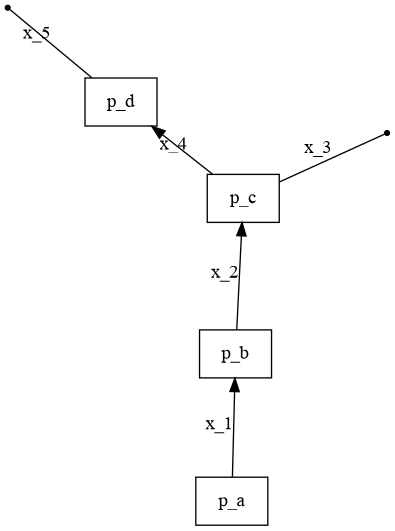

In [21]:
dot"""
digraph ForneyFactorGraph {
    // Nodes (factors)
    pa [label="p_a", shape=box];
    pb [label="p_b", shape=box];
    pc [label="p_c", shape=box];
    pd [label="p_d", shape=box];

    // Edges (variables)
    pa -> pb [label="x_1", len=1.5];
    pb -> pc [label="x_2", len=1.5];
    pc -> x3 [label="x_3", arrowhead=none, len=1.5];
    pd -> x5 [label="x_5", arrowhead=none, len=1.5];
    pc -> pd [label="x_4", len=1.5];

    // Invisible nodes for half-edges
    x3 [shape=point];
    x5 [shape=point];
    
    // Set layout style
    layout = "neato";
}
"""

## Nodes with Internal Structure

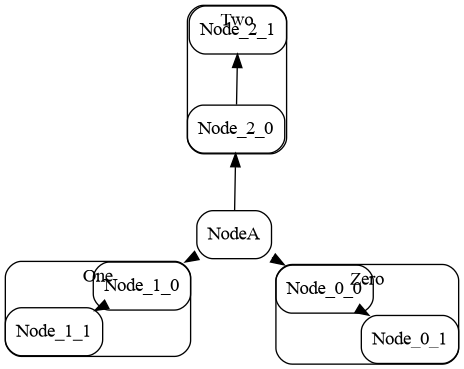

In [44]:
dot"""
digraph G {
  compound=true;
  node [ shape = "Mrecord" ];
  subgraph cluster_0 {
    style = rounded;
    label = "Zero";
	Node_0_0 -> Node_0_1;
  };
  subgraph cluster_1 {
    style = rounded;
    label = "One";
 	Node_1_0 -> Node_1_1;
  };
  subgraph cluster_2 {
    style = rounded;
    label = "Two";
    Node_2_0 -> Node_2_1;
  };
  NodeA [ style = rounded ];
  NodeA -> Node_0_0 [lhead = cluster_0];
  NodeA -> Node_1_0 [lhead = cluster_1];
  NodeA -> Node_2_0 [lhead = cluster_2];
}
"""

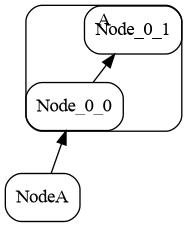

In [46]:
dot"""
digraph G {
  compound=true;
  node [ shape = "Mrecord" ];

  subgraph cluster_0 {
    style = rounded;
    label = "A";
	Node_0_0 -> Node_0_1;
  };

  NodeA [ style = rounded ];
  NodeA -> Node_0_0 [lhead = cluster_0];
}
"""

# Linear Regression Model

In [17]:
function generate_data(a, b, v, nr_samples; rng=StableRNG(1234))
    x = float.(collect(1:nr_samples))
    y = a .* x .+ b .+ randn(rng, nr_samples) .* sqrt(v)
    return x, y
end;

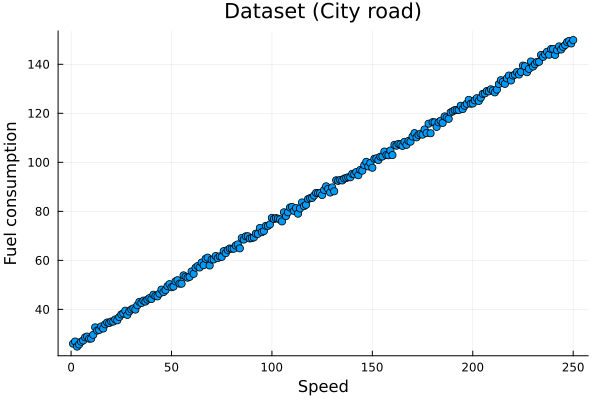

In [18]:
x_data, y_data = generate_data(0.5, 25.0, 1.0, 250)

scatter(x_data, y_data, title = "Dataset (City road)", legend=false)
xlabel!("Speed")
ylabel!("Fuel consumption")

In [19]:
@model function linear_regression(x, y)
    a ~ Normal(mean = 0.0, variance = 1.0)
    b ~ Normal(mean = 0.0, variance = 100.0)    
    y .~ Normal(mean = a .* x .+ b, variance = 1.0)
end

In [20]:
# Prepare the data
x_data = [1.0, 2.0, 3.0, 4.0, 5.0]  # example input data
y_data = [2.0, 4.1, 6.2, 8.3, 10.4];  # example observed data

In [21]:
linr_conditioned = linear_regression() | (x = x_data, y = y_data, );

In [22]:
# Create the RxInfer model and inject the data
linr_rxi_model = GraphPPL.create_model(linr_conditioned);

In [23]:
# Extract the GraphPPL.Model
linr_gppl_model = RxInfer.getmodel(linr_rxi_model);

In [24]:
# Extract the MetaGraphsNext meta graph
linr_meta_graph = linr_gppl_model.graph;

In [25]:
collect(labels(linr_meta_graph))

48-element Vector{GraphPPL.NodeLabel}:
 a_1
 constvar_2
 constvar_3
 NormalMeanVariance_4
 b_5
 constvar_6
 constvar_7
 NormalMeanVariance_8
 x_9
 x_10
 x_11
 x_12
 x_13
 ⋮
 y_37
 y_38
 constvar_39
 NormalMeanVariance_40
 constvar_41
 NormalMeanVariance_42
 constvar_43
 NormalMeanVariance_44
 constvar_45
 NormalMeanVariance_46
 constvar_47
 NormalMeanVariance_48

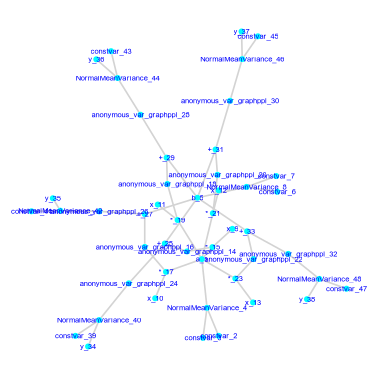

In [26]:
# The existing plotting functionality:
GraphPlot.gplot(
    linr_meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(linr_meta_graph)),
    nodelabelsize=0.1,
    NODESIZE=0.02, # diameter of the nodes,
    NODELABELSIZE=2,
    nodelabelc="blue",
    nodelabeldist=0.0,
    nodefillc="cyan"
)

In [16]:
Graphs.is_cyclic(linr_meta_graph)

true

In [27]:
# create the DOT code string
linr_model_dot = generate_dot(
    Model = linr_gppl_model,
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

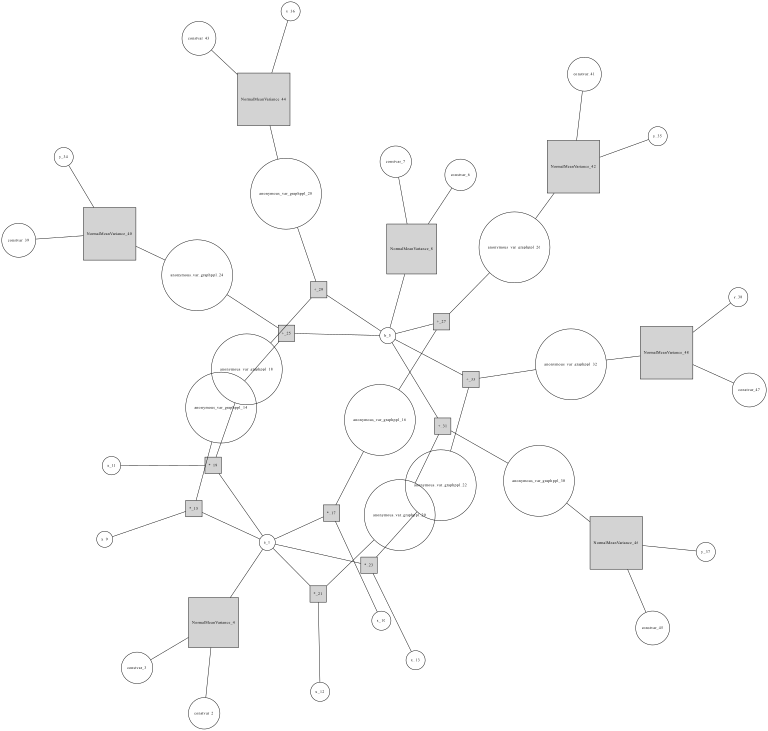

In [28]:
# execute the DOT code string
show_gv(linr_model_dot)

In [29]:
linr_model_dot_BFS, parents_linr = generate_dot_BFS(
    Model = linr_gppl_model,
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

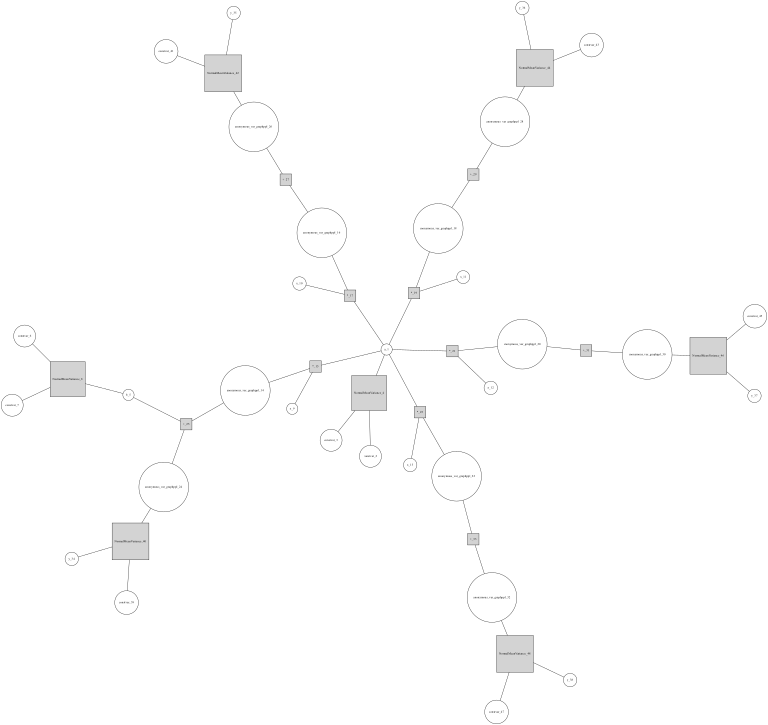

In [30]:
show_gv(linr_model_dot_BFS)

In [106]:
source = 1
bfs_tree_graph = bfs_tree(linr_gppl_model.graph, source)

{48, 47} directed simple Int64 graph

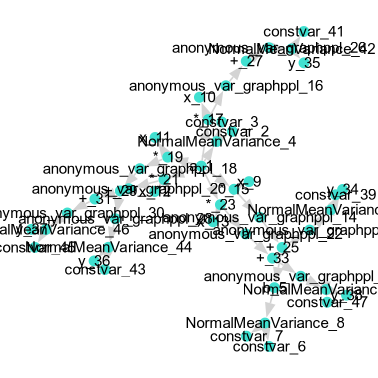

In [107]:
GraphPlot.gplot(
    bfs_tree_graph,
    nodelabel=collect(labels(linr_gppl_model.graph))
)

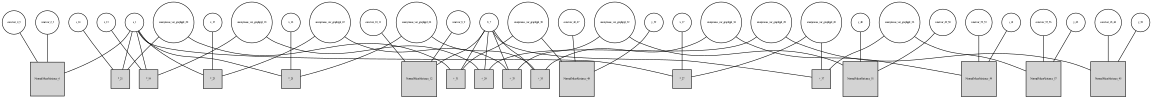

In [199]:
# Use a different graphViz layout engine: "dot"
linr_model_dot_2 = generate_dot(
    Model = linr_gppl_model,
    font_size = 5,
    edge_length = 2.5,
    layout = "dot",
    width = 12.0,
    height = 12.0
);

# execute the DOT code string
show_gv(linr_model_dot_2)

# Experimentation with Other Features (Highy Disorganised):

# Tikz/PGF

In [23]:
preamble = """\\documentclass{standalone}
\\usepackage{tikz}
\\usetikzlibrary{graphs,graphdrawing,quotes}
\\usegdlibrary{force}

\\begin{document}
\\begin{tikzpicture}
  \\graph [spring layout, node distance=20mm,
 nodes={draw, circle, fill=blue, text=white},
  edge quotes={fill=yellow, inner sep=2pt}]
  {\n"""

postamble = """};
\\end{tikzpicture}
\\end{document}"""

G = meta_graph

tex_code = preamble

for vertex in MetaGraphsNext.vertices(G)
    tex_code *= "    $(vertex) [as={\$n_{$(vertex)}\$}];\n"
end

for edge in MetaGraphsNext.edges(G)
    source_vertex = MetaGraphsNext.label_for(G, edge.src)
    dest_vertex = MetaGraphsNext.label_for(G, edge.dst)
    tex_code *= "    $(source_vertex) -- $(dest_vertex);\n"
end

tex_code *= postamble

# Write the TikZ code to a .tex file
file_path = "tikz_graph.tex"
open(file_path, "w") do file
    write(file, tex_code)
end

772

In [54]:
for edge in MetaGraphsNext.edges(meta_graph)
    println("$(edge.src)")
    println("$(MetaGraphsNext.label_for(meta_graph, edge.src))\n")
#     dot_code *= "    $(edge.src) -> $(edge.dst);"
end

1
θ_1

1
θ_1

1
θ_1

1
θ_1

2
constvar_2_3

3
constvar_4_5

5
y_7

7
y_9

9
y_11



In [55]:
for edge in MetaGraphsNext.edges(meta_graph)
    println("$(edge.dst)")
    println("$(MetaGraphsNext.label_for(meta_graph, edge.src))\n")
#     dot_code *= "    $(edge.src) -> $(edge.dst);"
end

4
Beta_6

6
Bernoulli_8

8
Bernoulli_10

10
Bernoulli_12

4
Beta_6

4
Beta_6

6
Bernoulli_8

8
Bernoulli_10

10
Bernoulli_12



In [27]:
typeof(MetaGraphsNext.edges(meta_graph))

Graphs.SimpleGraphs.SimpleEdgeIter{Graphs.SimpleGraphs.SimpleGraph{Int64}}

In [33]:
MetaGraphsNext.label_for(meta_graph, 1)

GraphPPL.NodeLabel

In [39]:
for i in 1:length(collect(labels(meta_graph)))
    println(MetaGraphsNext.label_for(meta_graph, i))
end

θ_1
constvar_2_3
constvar_4_5
Beta_6
y_7
Bernoulli_8
y_9
Bernoulli_10
y_11
Bernoulli_12


In [40]:
collect(labels(meta_graph))

10-element Vector{GraphPPL.NodeLabel}:
 θ_1
 constvar_2_3
 constvar_4_5
 Beta_6
 y_7
 Bernoulli_8
 y_9
 Bernoulli_10
 y_11
 Bernoulli_12

In [44]:
for vertex in MetaGraphsNext.vertices(meta_graph)  # add nodes
    println(MetaGraphsNext.label_for(meta_graph, vertex))
end

θ_1
constvar_2_3
constvar_4_5
Beta_6
y_7
Bernoulli_8
y_9
Bernoulli_10
y_11
Bernoulli_12


# Old Functionality (String Concat)

In [151]:
"""
A helper function to wrap GraphViz DOT code in the 
command string used with GraphViz.jl 
"""
function wrap_dot_code(dot_code::String)
    return "dot\"\"\"\n$dot_code\n\"\"\""
end

wrap_dot_code

In [169]:
"""
Basic visualisation of a GraphPPL.Model with GraphViz.
Isomorphic to the display given by GraphPlot.gplot.
"""
function show_gv_V2(; Model::GraphPPL.Model, font_size::Int, edge_length::Float64 = 1.0)
    
    meta_graph = Model.graph # underlying MetaGraphsNext graph
    
    
    dot_code = """
    graph G {
        node [shape=circle, fontsize=$(font_size)];
    """
    
    # Vertices/Nodes
    for vertex in MetaGraphsNext.vertices(meta_graph)
        label = MetaGraphsNext.label_for(meta_graph, vertex)
        
        properties = Model[label].properties # for dsistnguishing factor/variable nodes
        
        if isa(properties, GraphPPL.FactorNodeProperties) # Factor node
            dot_code *= "    \"$(label)\" [shape=square, style=filled, fillcolor=lightgray];\n"
        elseif isa(properties, GraphPPL.VariableNodeProperties) # Variable Node
            dot_code *= "    \"$(label)\" [shape=circle];\n"
        else
            println("ERROR: Unknown node type for label $(label)")
        end
    end
    
    # Edges
    for edge in MetaGraphsNext.edges(meta_graph)
        source_vertex = MetaGraphsNext.label_for(meta_graph, edge.src)
        dest_vertex = MetaGraphsNext.label_for(meta_graph, edge.dst)
        dot_code *= "    \"$(source_vertex)\" -- \"$(dest_vertex)\" [len=$(edge_length)];\n"
    end
    
    dot_code *= "}"

    wrapped_dot_code = wrap_dot_code(dot_code)
    
    eval(Meta.parse(wrapped_dot_code)) # not ideal, but used for this example
end

show_gv_V2

In [170]:
"""
Basic visualisation a GraphPPL.Model with GraphViz.
Isomorphic to the display given by GraphPlot.gplot.
"""
function show_gv_OG(; Model::GraphPPL.Model, font_size::Int)
    
    meta_graph = Model.graph # underlying MetaGraphsNext graph
    
    dot_code = """
    graph G {
        node [shape=circle, fontsize=$(font_size)];
    """

#     for vertex in MetaGraphsNext.vertices(G)  # add nodes
#         dot_code *="    $(MetaGraphsNext.label_for(G, vertex));\n"
#     end
    
    for vertex in MetaGraphsNext.vertices(meta_graph)
        label = MetaGraphsNext.label_for(meta_graph, vertex)
        if isa(Model[label].properties, GraphPPL.FactorNodeProperties{GraphPPL.NodeData})
            dot_code *="    $(MetaGraphsNext.label_for(meta_graph, vertex)) [shape=square];\n"
        elseif isa(Model[label].properties, GraphPPL.VariableNodeProperties{GraphPPL.NodeData})
            dot_code *="    $(MetaGraphsNext.label_for(meta_graph, vertex)) [shape=circle];\n"
        else
            println("ERROR")
        end
    end
    
#     for (factor_id, node_label) in pairs(gppl_model_context.factor_nodes)
#         # get vertex code from the meta graph
#         # test if this vertex code belongs to a node factor 
#         #     if yes, make this node's shape square
#         println("TESTING")
#     end

    for edge in MetaGraphsNext.edges(meta_graph)  # add edges
        source_vertex = MetaGraphsNext.label_for(meta_graph, edge.src)
        dest_vertex = MetaGraphsNext.label_for(meta_graph, edge.dst)
        dot_code *= "    $(source_vertex) -- $(dest_vertex);\n"
    end
    
    dot_code *= "}"

    wrapped_dot_code = wrap_dot_code(dot_code)
    
    eval(Meta.parse(wrapped_dot_code)) # not ideal 

end

show_gv_OG